<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_identical_generators_and_1_Classifier_ver7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
##!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

(60000, 28, 28)
(10000, 56, 56)


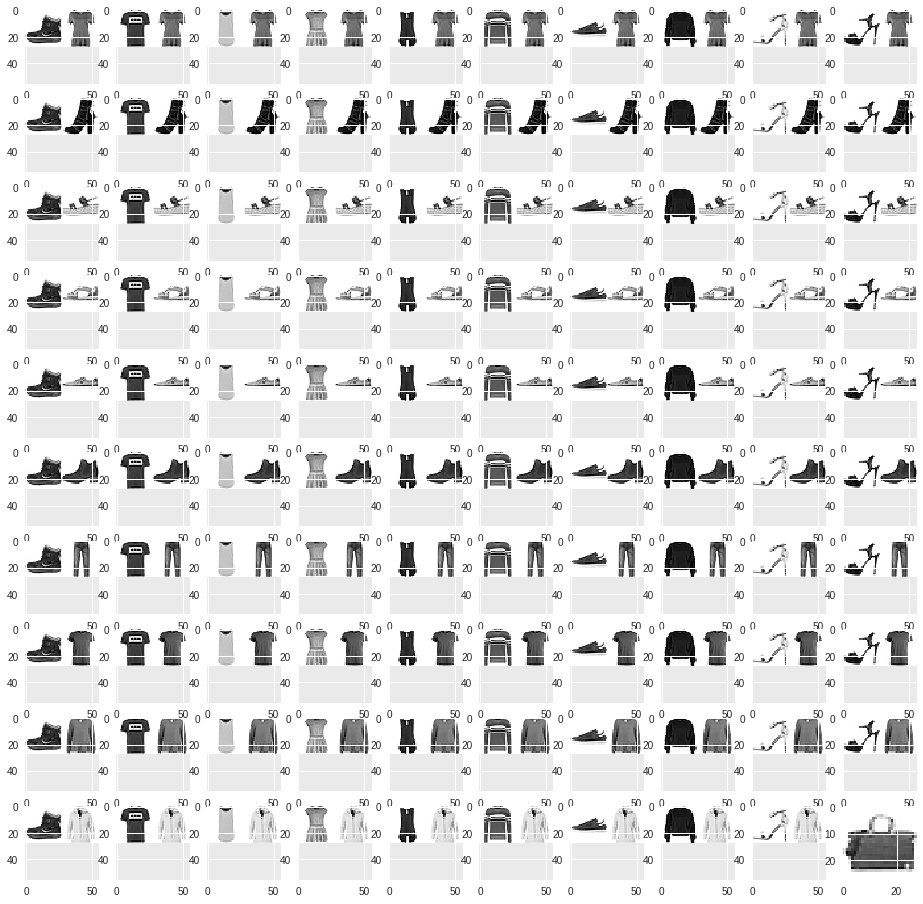

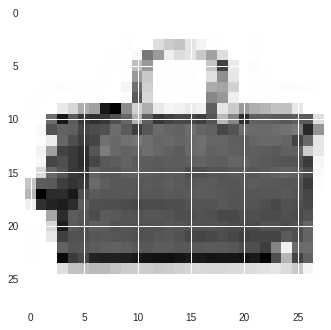

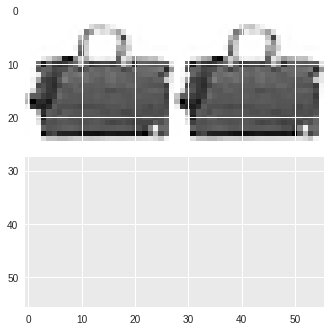

In [5]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0] / 5
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator1.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            else :
              fake_images = fake_images2
              fake_labels = fake_labels2
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
 ##   models = [generator1, generator2]
    models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [17]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW()


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  12000.0
Number of Batches:  375
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/375 [D loss: 0.918683, acc.: 34.38%] [G loss: 0.737332]


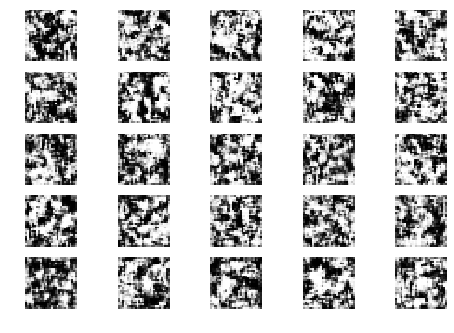

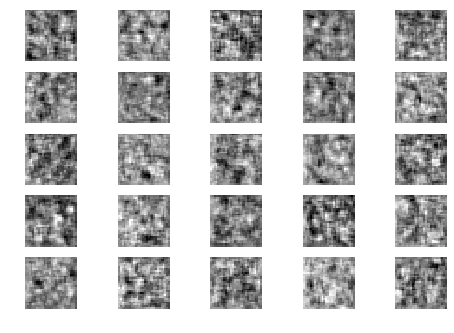

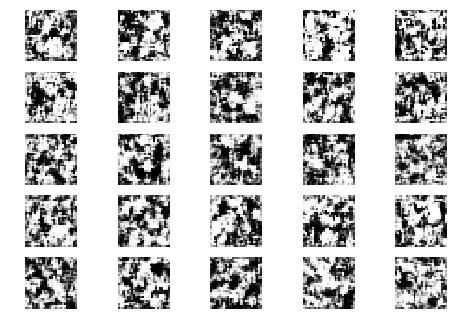

Epoch 0 Batch 1/375 [D loss: 0.673479, acc.: 59.38%] [G loss: 0.767268]
Epoch 0 Batch 2/375 [D loss: 0.427218, acc.: 81.25%] [G loss: 0.959398]
Epoch 0 Batch 3/375 [D loss: 0.455202, acc.: 84.38%] [G loss: 1.006273]
Epoch 0 Batch 4/375 [D loss: 0.412691, acc.: 81.25%] [G loss: 1.338207]
Epoch 0 Batch 5/375 [D loss: 0.406686, acc.: 84.38%] [G loss: 1.314167]
Epoch 0 Batch 6/375 [D loss: 0.425970, acc.: 81.25%] [G loss: 1.368158]
Epoch 0 Batch 7/375 [D loss: 0.275938, acc.: 93.75%] [G loss: 1.752543]
Epoch 0 Batch 8/375 [D loss: 0.271505, acc.: 87.50%] [G loss: 2.053499]
Epoch 0 Batch 9/375 [D loss: 0.208811, acc.: 96.88%] [G loss: 2.008307]
Epoch 0 Batch 10/375 [D loss: 0.219559, acc.: 96.88%] [G loss: 2.193245]
Epoch 0 Batch 11/375 [D loss: 0.218871, acc.: 96.88%] [G loss: 2.049302]
Epoch 0 Batch 12/375 [D loss: 0.151573, acc.: 96.88%] [G loss: 1.970217]
Epoch 0 Batch 13/375 [D loss: 0.197158, acc.: 93.75%] [G loss: 1.920419]
Epoch 0 Batch 14/375 [D loss: 0.158424, acc.: 96.88%] [G los

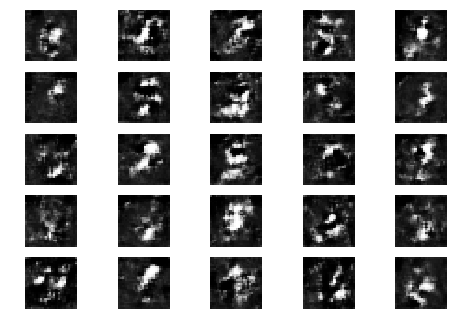

Epoch 0 Batch 101/375 [D loss: 0.810561, acc.: 46.88%] [G loss: 1.699687]


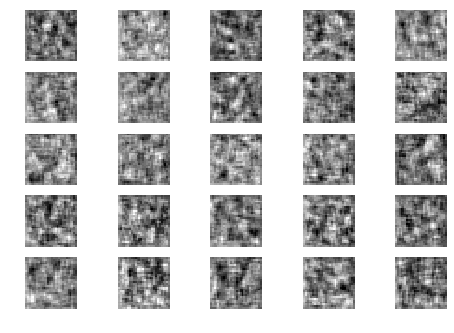

Epoch 0 Batch 102/375 [D loss: 1.615877, acc.: 31.25%] [G loss: 2.306997]


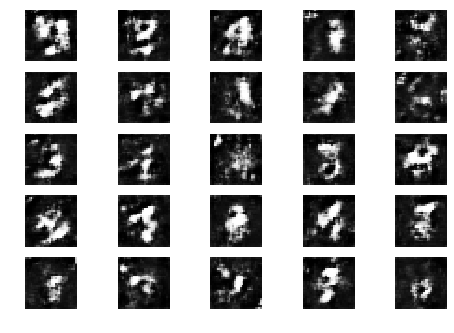

Epoch 0 Batch 103/375 [D loss: 1.131667, acc.: 46.88%] [G loss: 2.204499]
Epoch 0 Batch 104/375 [D loss: 1.553472, acc.: 34.38%] [G loss: 1.385710]
Epoch 0 Batch 105/375 [D loss: 0.800519, acc.: 50.00%] [G loss: 1.807878]
Epoch 0 Batch 106/375 [D loss: 0.931967, acc.: 46.88%] [G loss: 1.325217]
Epoch 0 Batch 107/375 [D loss: 0.854808, acc.: 50.00%] [G loss: 2.232648]
Epoch 0 Batch 108/375 [D loss: 0.702147, acc.: 65.62%] [G loss: 1.971969]
Epoch 0 Batch 109/375 [D loss: 0.963027, acc.: 46.88%] [G loss: 0.944972]
Epoch 0 Batch 110/375 [D loss: 1.061244, acc.: 53.12%] [G loss: 2.522734]
Epoch 0 Batch 111/375 [D loss: 1.048871, acc.: 46.88%] [G loss: 1.199375]
Epoch 0 Batch 112/375 [D loss: 1.062007, acc.: 53.12%] [G loss: 1.359353]
Epoch 0 Batch 113/375 [D loss: 0.815730, acc.: 56.25%] [G loss: 2.042049]
Epoch 0 Batch 114/375 [D loss: 0.779455, acc.: 62.50%] [G loss: 1.868754]
Epoch 0 Batch 115/375 [D loss: 0.760901, acc.: 53.12%] [G loss: 1.621533]
Epoch 0 Batch 116/375 [D loss: 0.81162

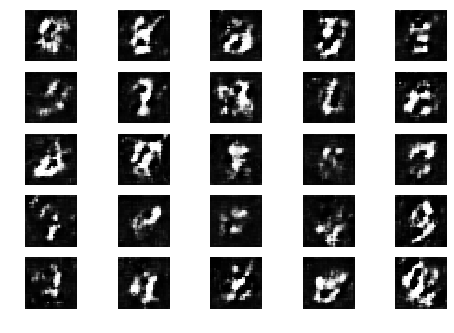

Epoch 0 Batch 201/375 [D loss: 0.727217, acc.: 59.38%] [G loss: 1.423230]
Epoch 0 Batch 202/375 [D loss: 0.885295, acc.: 46.88%] [G loss: 1.246499]


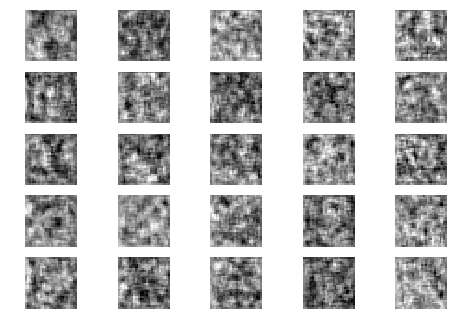

Epoch 0 Batch 203/375 [D loss: 1.043881, acc.: 34.38%] [G loss: 1.037694]
Epoch 0 Batch 204/375 [D loss: 0.756339, acc.: 43.75%] [G loss: 1.528247]


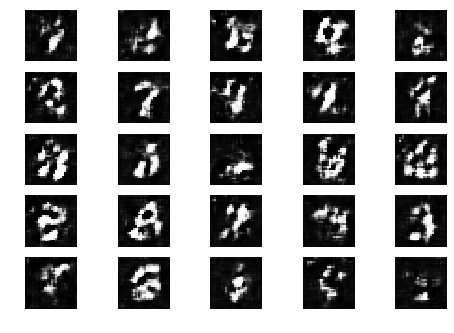

Epoch 0 Batch 205/375 [D loss: 0.915883, acc.: 50.00%] [G loss: 1.452014]
Epoch 0 Batch 206/375 [D loss: 0.549135, acc.: 75.00%] [G loss: 1.392529]
Epoch 0 Batch 207/375 [D loss: 0.745283, acc.: 62.50%] [G loss: 1.126729]
Epoch 0 Batch 208/375 [D loss: 0.644449, acc.: 68.75%] [G loss: 1.525900]
Epoch 0 Batch 209/375 [D loss: 0.836913, acc.: 40.62%] [G loss: 1.421732]
Epoch 0 Batch 210/375 [D loss: 0.868400, acc.: 53.12%] [G loss: 1.098720]
Epoch 0 Batch 211/375 [D loss: 0.610604, acc.: 75.00%] [G loss: 1.258968]
Epoch 0 Batch 212/375 [D loss: 0.856075, acc.: 56.25%] [G loss: 1.232463]
Epoch 0 Batch 213/375 [D loss: 0.836086, acc.: 46.88%] [G loss: 1.484774]
Epoch 0 Batch 214/375 [D loss: 0.627360, acc.: 62.50%] [G loss: 1.629560]
Epoch 0 Batch 215/375 [D loss: 0.838402, acc.: 53.12%] [G loss: 1.263414]
Epoch 0 Batch 216/375 [D loss: 0.823651, acc.: 53.12%] [G loss: 1.141859]
Epoch 0 Batch 217/375 [D loss: 0.817449, acc.: 56.25%] [G loss: 1.163239]
Epoch 0 Batch 218/375 [D loss: 0.66221

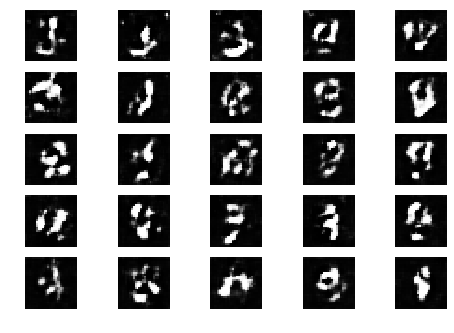

Epoch 0 Batch 301/375 [D loss: 0.914351, acc.: 50.00%] [G loss: 1.031187]
Epoch 0 Batch 302/375 [D loss: 0.680805, acc.: 62.50%] [G loss: 1.280033]
Epoch 0 Batch 303/375 [D loss: 1.080906, acc.: 40.62%] [G loss: 1.026323]


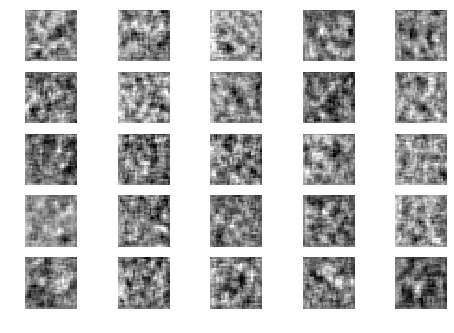

Epoch 0 Batch 304/375 [D loss: 0.681976, acc.: 59.38%] [G loss: 1.276686]
Epoch 0 Batch 305/375 [D loss: 0.828146, acc.: 43.75%] [G loss: 1.495993]
Epoch 0 Batch 306/375 [D loss: 0.863022, acc.: 43.75%] [G loss: 1.247259]


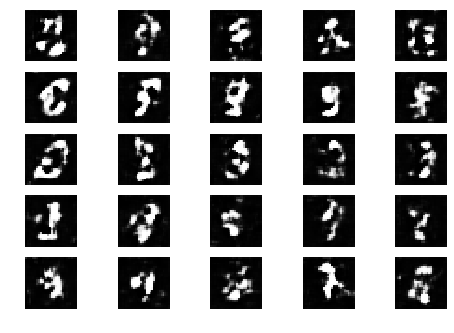

Epoch 0 Batch 307/375 [D loss: 0.460298, acc.: 75.00%] [G loss: 1.309161]
Epoch 0 Batch 308/375 [D loss: 0.808872, acc.: 62.50%] [G loss: 1.206567]
Epoch 0 Batch 309/375 [D loss: 0.790744, acc.: 56.25%] [G loss: 0.944299]
Epoch 0 Batch 310/375 [D loss: 0.751517, acc.: 65.62%] [G loss: 1.197725]
Epoch 0 Batch 311/375 [D loss: 0.880601, acc.: 46.88%] [G loss: 1.249743]
Epoch 0 Batch 312/375 [D loss: 0.723443, acc.: 65.62%] [G loss: 1.031389]
Epoch 0 Batch 313/375 [D loss: 0.773603, acc.: 50.00%] [G loss: 1.241332]
Epoch 0 Batch 314/375 [D loss: 0.720113, acc.: 46.88%] [G loss: 1.127771]
Epoch 0 Batch 315/375 [D loss: 0.674667, acc.: 56.25%] [G loss: 1.154281]
Epoch 0 Batch 316/375 [D loss: 0.834658, acc.: 53.12%] [G loss: 1.288222]
Epoch 0 Batch 317/375 [D loss: 0.754465, acc.: 53.12%] [G loss: 1.270701]
Epoch 0 Batch 318/375 [D loss: 0.752835, acc.: 46.88%] [G loss: 1.091567]
Epoch 0 Batch 319/375 [D loss: 0.685889, acc.: 56.25%] [G loss: 1.173837]
Epoch 0 Batch 320/375 [D loss: 1.01744

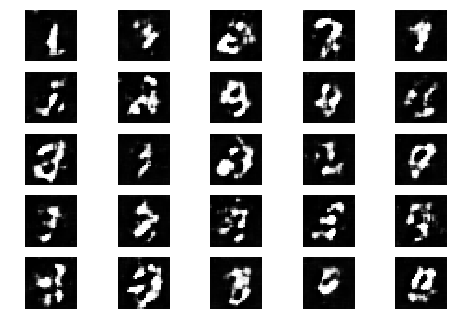

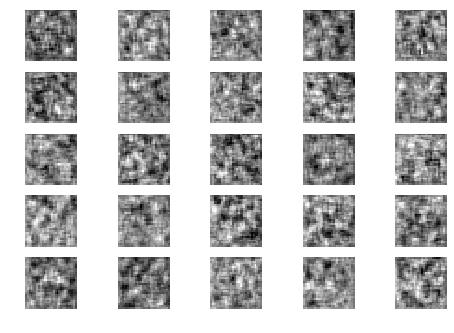

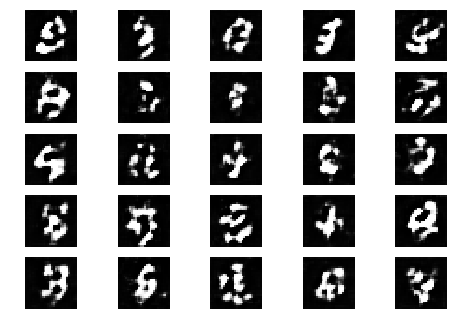

Epoch 1 Batch 1/375 [D loss: 0.733764, acc.: 53.12%] [G loss: 1.031807]
Epoch 1 Batch 2/375 [D loss: 0.601783, acc.: 68.75%] [G loss: 1.246636]
Epoch 1 Batch 3/375 [D loss: 0.710294, acc.: 53.12%] [G loss: 0.998685]
Epoch 1 Batch 4/375 [D loss: 0.642456, acc.: 62.50%] [G loss: 0.925571]
Epoch 1 Batch 5/375 [D loss: 0.764629, acc.: 59.38%] [G loss: 0.994819]
Epoch 1 Batch 6/375 [D loss: 0.797697, acc.: 43.75%] [G loss: 1.406763]
Epoch 1 Batch 7/375 [D loss: 0.796827, acc.: 53.12%] [G loss: 1.017576]
Epoch 1 Batch 8/375 [D loss: 0.636236, acc.: 56.25%] [G loss: 1.026597]
Epoch 1 Batch 9/375 [D loss: 0.786483, acc.: 53.12%] [G loss: 1.199961]
Epoch 1 Batch 10/375 [D loss: 0.704056, acc.: 62.50%] [G loss: 1.017813]
Epoch 1 Batch 11/375 [D loss: 0.657766, acc.: 53.12%] [G loss: 1.205164]
Epoch 1 Batch 12/375 [D loss: 0.738234, acc.: 53.12%] [G loss: 1.036812]
Epoch 1 Batch 13/375 [D loss: 0.658557, acc.: 56.25%] [G loss: 1.030075]
Epoch 1 Batch 14/375 [D loss: 0.764721, acc.: 59.38%] [G los

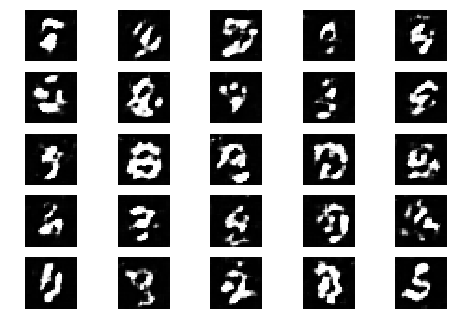

Epoch 1 Batch 101/375 [D loss: 0.752027, acc.: 50.00%] [G loss: 1.307330]


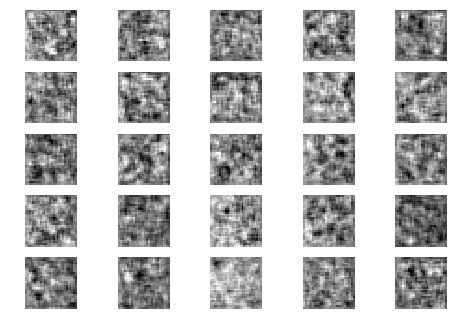

Epoch 1 Batch 102/375 [D loss: 0.732547, acc.: 56.25%] [G loss: 1.067879]


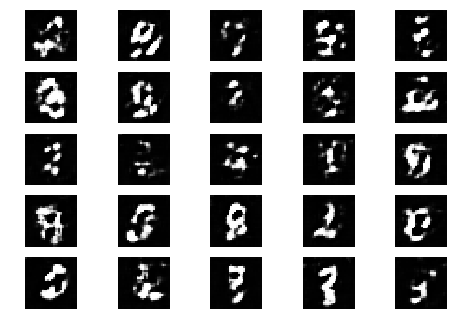

Epoch 1 Batch 103/375 [D loss: 0.675395, acc.: 68.75%] [G loss: 1.234930]
Epoch 1 Batch 104/375 [D loss: 0.640089, acc.: 68.75%] [G loss: 1.392606]
Epoch 1 Batch 105/375 [D loss: 0.624204, acc.: 71.88%] [G loss: 0.973523]
Epoch 1 Batch 106/375 [D loss: 0.726252, acc.: 50.00%] [G loss: 1.088760]
Epoch 1 Batch 107/375 [D loss: 0.791932, acc.: 50.00%] [G loss: 0.965569]
Epoch 1 Batch 108/375 [D loss: 0.625879, acc.: 75.00%] [G loss: 1.258916]
Epoch 1 Batch 109/375 [D loss: 0.833528, acc.: 46.88%] [G loss: 1.181374]
Epoch 1 Batch 110/375 [D loss: 0.624783, acc.: 71.88%] [G loss: 1.168747]
Epoch 1 Batch 111/375 [D loss: 0.710525, acc.: 53.12%] [G loss: 1.100546]
Epoch 1 Batch 112/375 [D loss: 0.771072, acc.: 46.88%] [G loss: 0.948799]
Epoch 1 Batch 113/375 [D loss: 0.673884, acc.: 53.12%] [G loss: 0.895583]
Epoch 1 Batch 114/375 [D loss: 0.727267, acc.: 56.25%] [G loss: 1.126370]
Epoch 1 Batch 115/375 [D loss: 0.733360, acc.: 56.25%] [G loss: 1.173520]
Epoch 1 Batch 116/375 [D loss: 0.84565

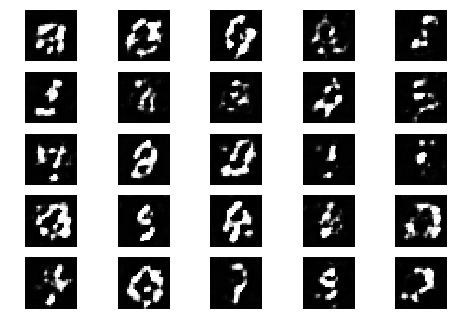

Epoch 1 Batch 201/375 [D loss: 0.661714, acc.: 53.12%] [G loss: 0.862933]
Epoch 1 Batch 202/375 [D loss: 0.589523, acc.: 62.50%] [G loss: 1.101379]


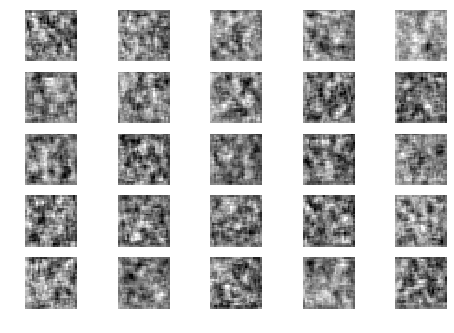

Epoch 1 Batch 203/375 [D loss: 0.637873, acc.: 71.88%] [G loss: 1.003334]
Epoch 1 Batch 204/375 [D loss: 0.809556, acc.: 50.00%] [G loss: 1.056519]


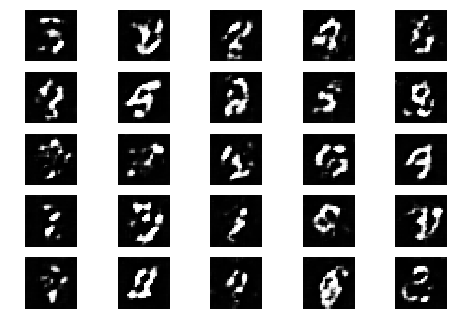

Epoch 1 Batch 205/375 [D loss: 0.806266, acc.: 46.88%] [G loss: 1.218036]
Epoch 1 Batch 206/375 [D loss: 0.728277, acc.: 56.25%] [G loss: 0.975032]
Epoch 1 Batch 207/375 [D loss: 0.724301, acc.: 59.38%] [G loss: 1.118518]
Epoch 1 Batch 208/375 [D loss: 0.591760, acc.: 62.50%] [G loss: 1.260291]
Epoch 1 Batch 209/375 [D loss: 0.648303, acc.: 56.25%] [G loss: 1.046287]
Epoch 1 Batch 210/375 [D loss: 0.728357, acc.: 53.12%] [G loss: 1.126018]
Epoch 1 Batch 211/375 [D loss: 0.665548, acc.: 59.38%] [G loss: 0.980143]
Epoch 1 Batch 212/375 [D loss: 0.970872, acc.: 34.38%] [G loss: 1.295510]
Epoch 1 Batch 213/375 [D loss: 0.620436, acc.: 62.50%] [G loss: 0.916978]
Epoch 1 Batch 214/375 [D loss: 0.693008, acc.: 59.38%] [G loss: 0.999058]
Epoch 1 Batch 215/375 [D loss: 0.664742, acc.: 65.62%] [G loss: 1.407540]
Epoch 1 Batch 216/375 [D loss: 0.804438, acc.: 50.00%] [G loss: 0.992365]
Epoch 1 Batch 217/375 [D loss: 0.745663, acc.: 50.00%] [G loss: 1.195990]
Epoch 1 Batch 218/375 [D loss: 0.59723

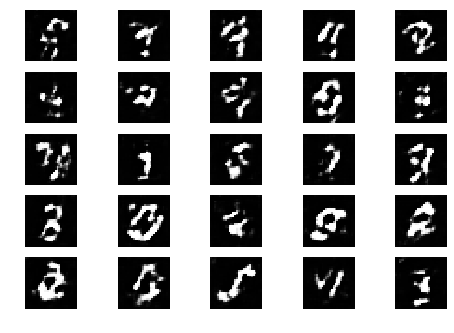

Epoch 1 Batch 301/375 [D loss: 0.876425, acc.: 43.75%] [G loss: 1.256653]
Epoch 1 Batch 302/375 [D loss: 0.620333, acc.: 71.88%] [G loss: 1.063091]
Epoch 1 Batch 303/375 [D loss: 0.697348, acc.: 56.25%] [G loss: 1.300745]


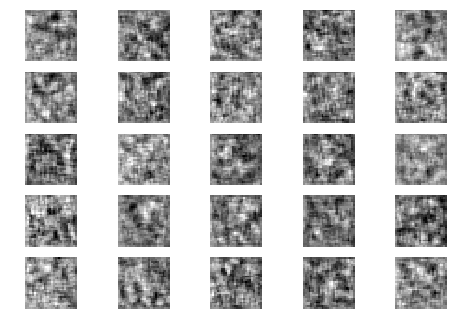

Epoch 1 Batch 304/375 [D loss: 0.697257, acc.: 56.25%] [G loss: 1.012442]
Epoch 1 Batch 305/375 [D loss: 0.561231, acc.: 75.00%] [G loss: 1.132987]
Epoch 1 Batch 306/375 [D loss: 0.925829, acc.: 34.38%] [G loss: 1.036605]


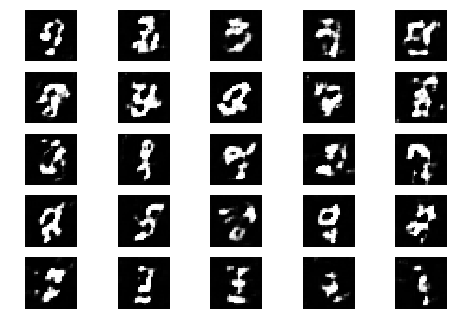

Epoch 1 Batch 307/375 [D loss: 0.590216, acc.: 68.75%] [G loss: 1.357831]
Epoch 1 Batch 308/375 [D loss: 0.421258, acc.: 84.38%] [G loss: 1.323389]
Epoch 1 Batch 309/375 [D loss: 0.723726, acc.: 50.00%] [G loss: 0.885105]
Epoch 1 Batch 310/375 [D loss: 0.920633, acc.: 43.75%] [G loss: 0.897067]
Epoch 1 Batch 311/375 [D loss: 0.613509, acc.: 71.88%] [G loss: 1.218410]
Epoch 1 Batch 312/375 [D loss: 0.667959, acc.: 56.25%] [G loss: 1.367106]
Epoch 1 Batch 313/375 [D loss: 0.475077, acc.: 81.25%] [G loss: 1.209562]
Epoch 1 Batch 314/375 [D loss: 0.623533, acc.: 56.25%] [G loss: 1.258238]
Epoch 1 Batch 315/375 [D loss: 0.707063, acc.: 62.50%] [G loss: 1.141597]
Epoch 1 Batch 316/375 [D loss: 0.600922, acc.: 65.62%] [G loss: 1.131167]
Epoch 1 Batch 317/375 [D loss: 0.662059, acc.: 56.25%] [G loss: 1.279347]
Epoch 1 Batch 318/375 [D loss: 0.589747, acc.: 75.00%] [G loss: 1.386342]
Epoch 1 Batch 319/375 [D loss: 0.874558, acc.: 34.38%] [G loss: 1.106322]
Epoch 1 Batch 320/375 [D loss: 0.55690

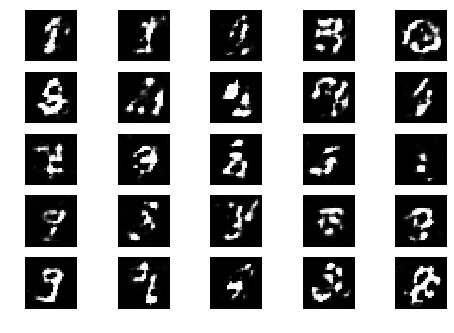

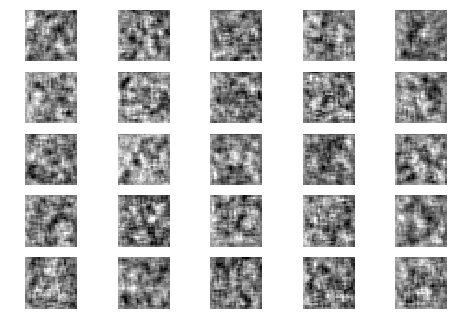

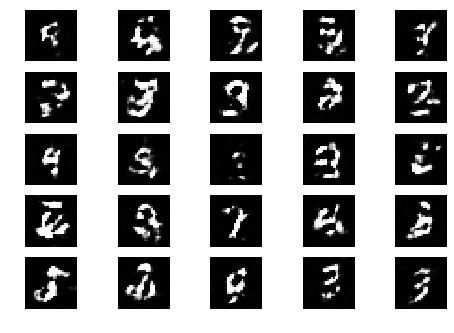

Epoch 2 Batch 1/375 [D loss: 0.811237, acc.: 40.62%] [G loss: 1.474739]
Epoch 2 Batch 2/375 [D loss: 0.679545, acc.: 62.50%] [G loss: 1.280636]
Epoch 2 Batch 3/375 [D loss: 0.682470, acc.: 53.12%] [G loss: 0.922523]
Epoch 2 Batch 4/375 [D loss: 0.516431, acc.: 81.25%] [G loss: 1.287680]
Epoch 2 Batch 5/375 [D loss: 0.605759, acc.: 75.00%] [G loss: 1.011096]
Epoch 2 Batch 6/375 [D loss: 0.648969, acc.: 59.38%] [G loss: 1.030856]
Epoch 2 Batch 7/375 [D loss: 0.528469, acc.: 71.88%] [G loss: 1.214138]
Epoch 2 Batch 8/375 [D loss: 0.715411, acc.: 56.25%] [G loss: 1.157908]
Epoch 2 Batch 9/375 [D loss: 0.636710, acc.: 68.75%] [G loss: 1.102327]
Epoch 2 Batch 10/375 [D loss: 0.851186, acc.: 50.00%] [G loss: 1.284350]
Epoch 2 Batch 11/375 [D loss: 0.613283, acc.: 68.75%] [G loss: 0.856177]
Epoch 2 Batch 12/375 [D loss: 0.455266, acc.: 71.88%] [G loss: 1.204211]
Epoch 2 Batch 13/375 [D loss: 0.641785, acc.: 65.62%] [G loss: 1.210928]
Epoch 2 Batch 14/375 [D loss: 0.620362, acc.: 65.62%] [G los

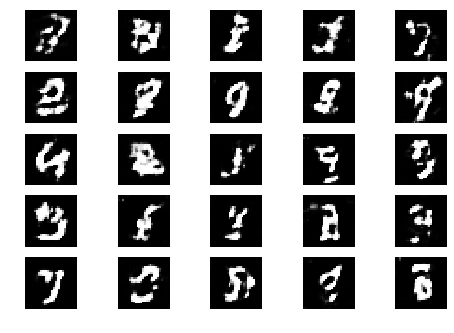

Epoch 2 Batch 101/375 [D loss: 0.692527, acc.: 62.50%] [G loss: 1.032300]


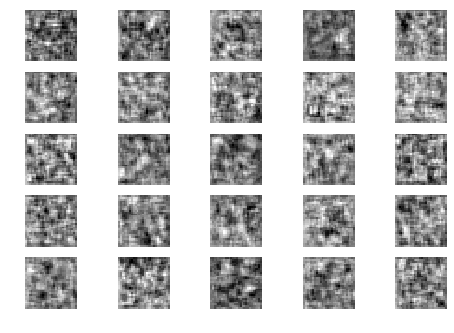

Epoch 2 Batch 102/375 [D loss: 0.643238, acc.: 62.50%] [G loss: 1.182809]


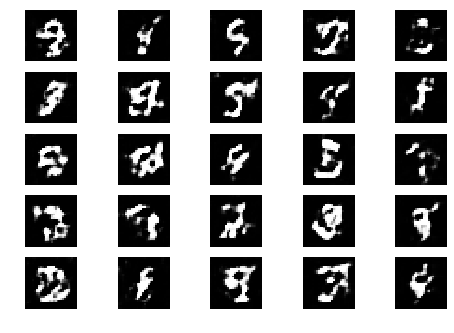

Epoch 2 Batch 103/375 [D loss: 0.425708, acc.: 81.25%] [G loss: 1.214634]
Epoch 2 Batch 104/375 [D loss: 0.783959, acc.: 56.25%] [G loss: 0.915363]
Epoch 2 Batch 105/375 [D loss: 0.523383, acc.: 75.00%] [G loss: 1.168183]
Epoch 2 Batch 106/375 [D loss: 0.759084, acc.: 50.00%] [G loss: 1.187529]
Epoch 2 Batch 107/375 [D loss: 0.725142, acc.: 53.12%] [G loss: 1.326686]
Epoch 2 Batch 108/375 [D loss: 0.611067, acc.: 56.25%] [G loss: 1.327637]
Epoch 2 Batch 109/375 [D loss: 0.557640, acc.: 65.62%] [G loss: 1.148070]
Epoch 2 Batch 110/375 [D loss: 0.678465, acc.: 62.50%] [G loss: 1.310345]
Epoch 2 Batch 111/375 [D loss: 0.833575, acc.: 43.75%] [G loss: 1.308633]
Epoch 2 Batch 112/375 [D loss: 0.787616, acc.: 40.62%] [G loss: 1.179022]
Epoch 2 Batch 113/375 [D loss: 0.577595, acc.: 68.75%] [G loss: 1.097132]
Epoch 2 Batch 114/375 [D loss: 0.652176, acc.: 59.38%] [G loss: 1.208794]
Epoch 2 Batch 115/375 [D loss: 0.770755, acc.: 50.00%] [G loss: 1.210188]
Epoch 2 Batch 116/375 [D loss: 0.62250

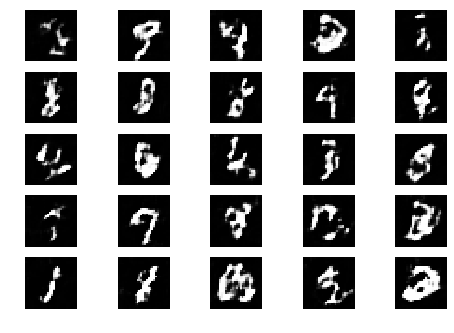

Epoch 2 Batch 201/375 [D loss: 0.726689, acc.: 46.88%] [G loss: 1.300238]
Epoch 2 Batch 202/375 [D loss: 0.558632, acc.: 62.50%] [G loss: 1.471372]


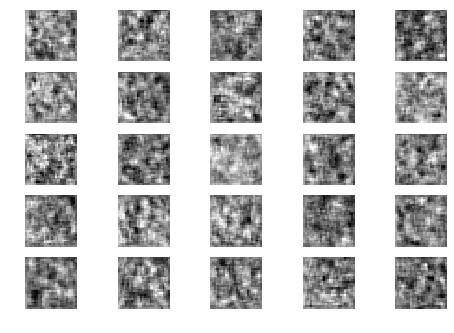

Epoch 2 Batch 203/375 [D loss: 0.480566, acc.: 84.38%] [G loss: 1.339163]
Epoch 2 Batch 204/375 [D loss: 0.641405, acc.: 65.62%] [G loss: 1.274047]


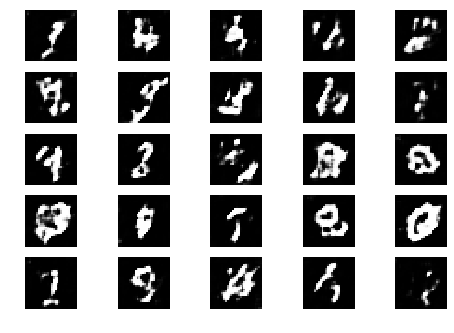

Epoch 2 Batch 205/375 [D loss: 0.579714, acc.: 65.62%] [G loss: 1.344292]
Epoch 2 Batch 206/375 [D loss: 0.613962, acc.: 65.62%] [G loss: 1.112018]
Epoch 2 Batch 207/375 [D loss: 0.734382, acc.: 56.25%] [G loss: 1.391766]
Epoch 2 Batch 208/375 [D loss: 0.637785, acc.: 56.25%] [G loss: 1.398107]
Epoch 2 Batch 209/375 [D loss: 0.539298, acc.: 71.88%] [G loss: 1.163725]
Epoch 2 Batch 210/375 [D loss: 0.798175, acc.: 62.50%] [G loss: 1.236720]
Epoch 2 Batch 211/375 [D loss: 0.599851, acc.: 62.50%] [G loss: 1.367207]
Epoch 2 Batch 212/375 [D loss: 0.611103, acc.: 71.88%] [G loss: 1.354968]
Epoch 2 Batch 213/375 [D loss: 0.596618, acc.: 71.88%] [G loss: 1.198911]
Epoch 2 Batch 214/375 [D loss: 0.649932, acc.: 65.62%] [G loss: 1.070135]
Epoch 2 Batch 215/375 [D loss: 0.658880, acc.: 62.50%] [G loss: 1.087749]
Epoch 2 Batch 216/375 [D loss: 0.626856, acc.: 65.62%] [G loss: 1.386977]
Epoch 2 Batch 217/375 [D loss: 0.613117, acc.: 68.75%] [G loss: 1.223583]
Epoch 2 Batch 218/375 [D loss: 0.68530

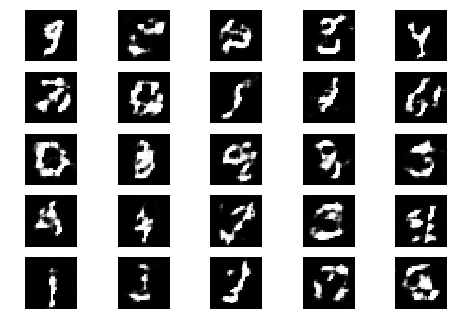

Epoch 2 Batch 301/375 [D loss: 0.532652, acc.: 75.00%] [G loss: 1.324936]
Epoch 2 Batch 302/375 [D loss: 0.896902, acc.: 37.50%] [G loss: 1.153361]
Epoch 2 Batch 303/375 [D loss: 0.788210, acc.: 50.00%] [G loss: 1.233850]


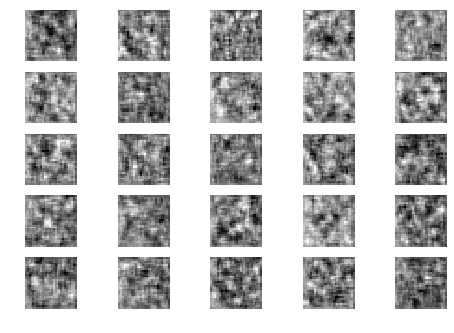

Epoch 2 Batch 304/375 [D loss: 0.673140, acc.: 71.88%] [G loss: 1.454252]
Epoch 2 Batch 305/375 [D loss: 0.498725, acc.: 75.00%] [G loss: 1.138236]
Epoch 2 Batch 306/375 [D loss: 0.670596, acc.: 62.50%] [G loss: 1.090953]


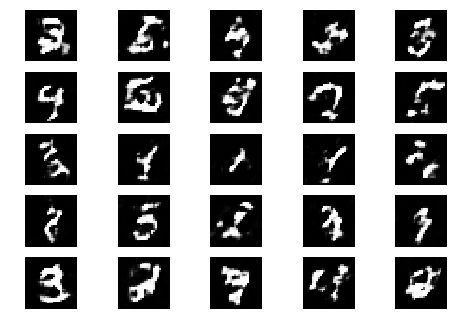

Epoch 2 Batch 307/375 [D loss: 0.689818, acc.: 68.75%] [G loss: 1.099707]
Epoch 2 Batch 308/375 [D loss: 0.625401, acc.: 71.88%] [G loss: 1.045273]
Epoch 2 Batch 309/375 [D loss: 0.671468, acc.: 68.75%] [G loss: 1.261052]
Epoch 2 Batch 310/375 [D loss: 0.613987, acc.: 62.50%] [G loss: 1.096388]
Epoch 2 Batch 311/375 [D loss: 0.807497, acc.: 46.88%] [G loss: 1.140551]
Epoch 2 Batch 312/375 [D loss: 0.788017, acc.: 56.25%] [G loss: 1.303778]
Epoch 2 Batch 313/375 [D loss: 0.668221, acc.: 59.38%] [G loss: 1.153787]
Epoch 2 Batch 314/375 [D loss: 0.544710, acc.: 75.00%] [G loss: 1.464143]
Epoch 2 Batch 315/375 [D loss: 0.817677, acc.: 46.88%] [G loss: 1.463381]
Epoch 2 Batch 316/375 [D loss: 0.721631, acc.: 59.38%] [G loss: 0.976029]
Epoch 2 Batch 317/375 [D loss: 0.604537, acc.: 56.25%] [G loss: 1.137150]
Epoch 2 Batch 318/375 [D loss: 0.472606, acc.: 75.00%] [G loss: 1.215822]
Epoch 2 Batch 319/375 [D loss: 0.716553, acc.: 53.12%] [G loss: 0.975575]
Epoch 2 Batch 320/375 [D loss: 0.65913

In [18]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

Number of examples:  12000.0
Number of Batches:  375
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)
Epoch 0 Batch 0/375 [D loss: 0.618291, acc.: 71.88%] [G loss: 0.992160]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


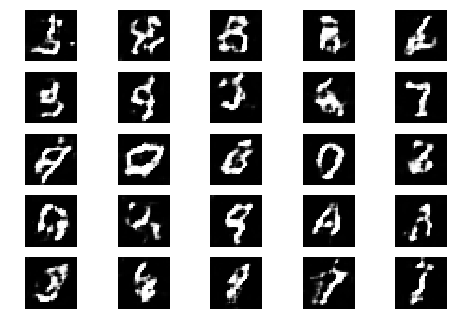

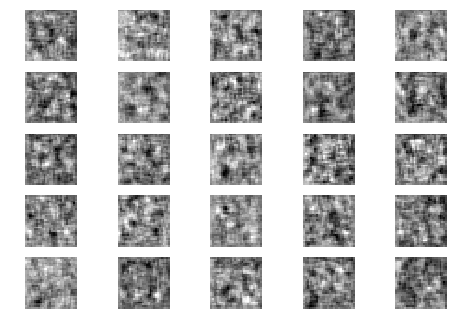

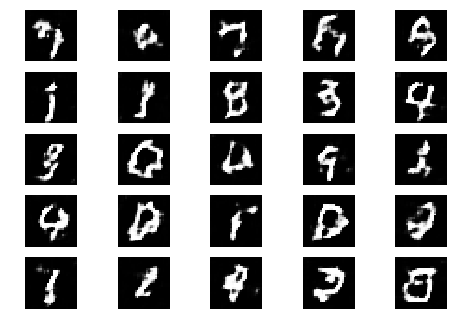

Epoch 0 Batch 1/375 [D loss: 0.659710, acc.: 59.38%] [G loss: 1.136896]
Epoch 0 Batch 2/375 [D loss: 0.676773, acc.: 65.62%] [G loss: 1.233903]
Epoch 0 Batch 3/375 [D loss: 0.566444, acc.: 68.75%] [G loss: 1.055663]
Epoch 0 Batch 4/375 [D loss: 0.574955, acc.: 62.50%] [G loss: 1.344923]
Epoch 0 Batch 5/375 [D loss: 0.777807, acc.: 59.38%] [G loss: 1.155225]
Epoch 0 Batch 6/375 [D loss: 0.871223, acc.: 46.88%] [G loss: 1.223822]
Epoch 0 Batch 7/375 [D loss: 0.826934, acc.: 50.00%] [G loss: 1.113028]
Epoch 0 Batch 8/375 [D loss: 0.895338, acc.: 46.88%] [G loss: 0.775202]
Epoch 0 Batch 9/375 [D loss: 0.576514, acc.: 71.88%] [G loss: 0.925376]
Epoch 0 Batch 10/375 [D loss: 0.573248, acc.: 78.12%] [G loss: 0.960278]
Epoch 0 Batch 11/375 [D loss: 0.586101, acc.: 68.75%] [G loss: 1.253179]
Epoch 0 Batch 12/375 [D loss: 0.828674, acc.: 50.00%] [G loss: 1.202140]
Epoch 0 Batch 13/375 [D loss: 0.682882, acc.: 65.62%] [G loss: 1.232086]
Epoch 0 Batch 14/375 [D loss: 0.649440, acc.: 62.50%] [G los

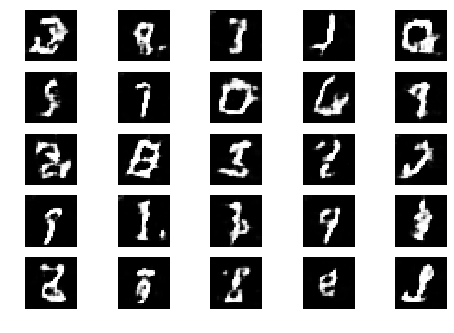

Epoch 0 Batch 101/375 [D loss: 0.607858, acc.: 68.75%] [G loss: 1.352044]


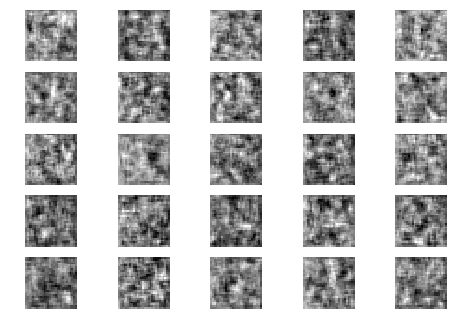

Epoch 0 Batch 102/375 [D loss: 0.533690, acc.: 71.88%] [G loss: 1.010162]


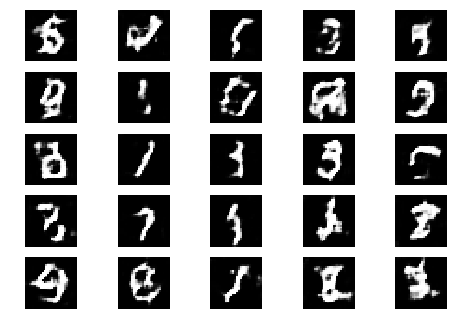

Epoch 0 Batch 103/375 [D loss: 0.732067, acc.: 50.00%] [G loss: 0.766763]
Epoch 0 Batch 104/375 [D loss: 0.558817, acc.: 68.75%] [G loss: 1.208538]
Epoch 0 Batch 105/375 [D loss: 0.627164, acc.: 65.62%] [G loss: 1.176896]
Epoch 0 Batch 106/375 [D loss: 0.653266, acc.: 53.12%] [G loss: 1.056006]
Epoch 0 Batch 107/375 [D loss: 0.705770, acc.: 68.75%] [G loss: 1.072621]
Epoch 0 Batch 108/375 [D loss: 0.628652, acc.: 65.62%] [G loss: 1.186876]
Epoch 0 Batch 109/375 [D loss: 0.720849, acc.: 46.88%] [G loss: 1.288767]
Epoch 0 Batch 110/375 [D loss: 0.610463, acc.: 65.62%] [G loss: 1.252601]
Epoch 0 Batch 111/375 [D loss: 0.741762, acc.: 50.00%] [G loss: 0.791086]
Epoch 0 Batch 112/375 [D loss: 0.482128, acc.: 78.12%] [G loss: 1.483269]
Epoch 0 Batch 113/375 [D loss: 0.635902, acc.: 59.38%] [G loss: 1.452464]
Epoch 0 Batch 114/375 [D loss: 0.707281, acc.: 59.38%] [G loss: 1.220748]
Epoch 0 Batch 115/375 [D loss: 0.632036, acc.: 59.38%] [G loss: 1.129803]
Epoch 0 Batch 116/375 [D loss: 0.62708

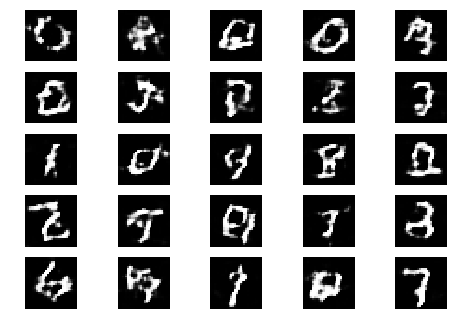

Epoch 0 Batch 201/375 [D loss: 0.869251, acc.: 56.25%] [G loss: 1.357593]
Epoch 0 Batch 202/375 [D loss: 0.696778, acc.: 62.50%] [G loss: 1.071739]


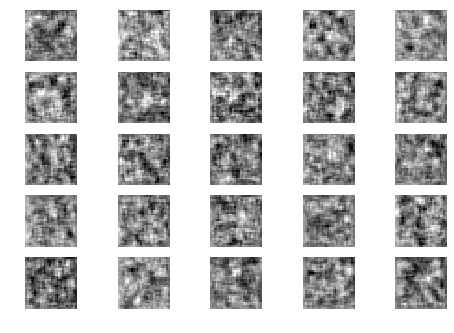

Epoch 0 Batch 203/375 [D loss: 0.618124, acc.: 59.38%] [G loss: 0.918946]
Epoch 0 Batch 204/375 [D loss: 0.735936, acc.: 46.88%] [G loss: 1.317963]


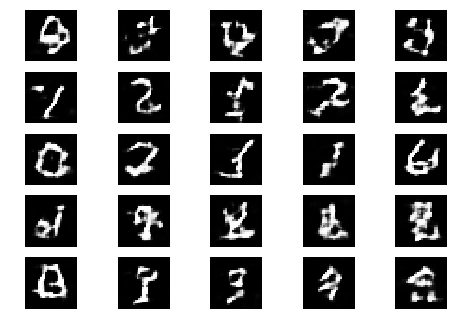

Epoch 0 Batch 205/375 [D loss: 0.820788, acc.: 56.25%] [G loss: 1.387912]
Epoch 0 Batch 206/375 [D loss: 0.696332, acc.: 62.50%] [G loss: 1.341606]
Epoch 0 Batch 207/375 [D loss: 0.647989, acc.: 62.50%] [G loss: 1.105232]
Epoch 0 Batch 208/375 [D loss: 0.981439, acc.: 37.50%] [G loss: 1.213908]
Epoch 0 Batch 209/375 [D loss: 0.674085, acc.: 59.38%] [G loss: 1.049031]
Epoch 0 Batch 210/375 [D loss: 0.615461, acc.: 65.62%] [G loss: 1.055413]
Epoch 0 Batch 211/375 [D loss: 0.605257, acc.: 65.62%] [G loss: 1.266969]
Epoch 0 Batch 212/375 [D loss: 0.651220, acc.: 65.62%] [G loss: 1.031452]
Epoch 0 Batch 213/375 [D loss: 0.649328, acc.: 62.50%] [G loss: 1.152606]
Epoch 0 Batch 214/375 [D loss: 0.848313, acc.: 50.00%] [G loss: 1.251331]
Epoch 0 Batch 215/375 [D loss: 0.628776, acc.: 71.88%] [G loss: 1.131648]
Epoch 0 Batch 216/375 [D loss: 0.562954, acc.: 71.88%] [G loss: 1.176918]
Epoch 0 Batch 217/375 [D loss: 0.703570, acc.: 53.12%] [G loss: 1.204114]
Epoch 0 Batch 218/375 [D loss: 0.74911

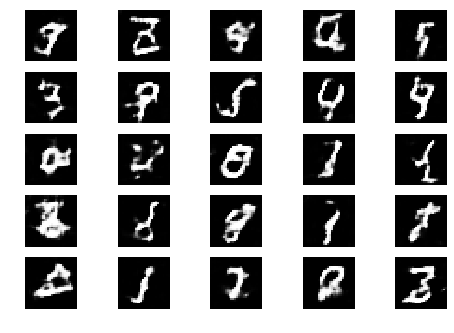

Epoch 0 Batch 301/375 [D loss: 0.596261, acc.: 78.12%] [G loss: 1.063335]
Epoch 0 Batch 302/375 [D loss: 0.624858, acc.: 62.50%] [G loss: 0.952015]
Epoch 0 Batch 303/375 [D loss: 0.592687, acc.: 75.00%] [G loss: 1.196747]


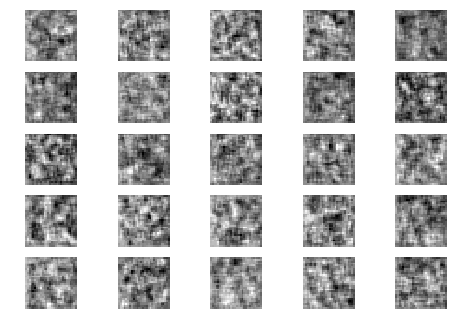

Epoch 0 Batch 304/375 [D loss: 0.788383, acc.: 46.88%] [G loss: 0.992456]
Epoch 0 Batch 305/375 [D loss: 0.738226, acc.: 56.25%] [G loss: 1.112659]
Epoch 0 Batch 306/375 [D loss: 0.673517, acc.: 56.25%] [G loss: 1.194152]


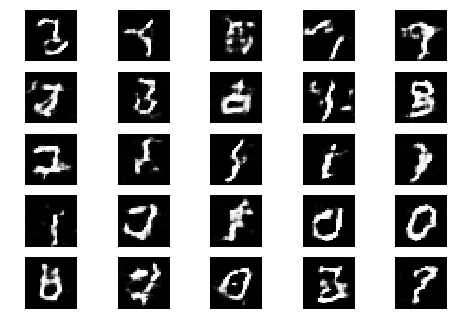

Epoch 0 Batch 307/375 [D loss: 0.551799, acc.: 68.75%] [G loss: 1.000104]
Epoch 0 Batch 308/375 [D loss: 0.592219, acc.: 71.88%] [G loss: 1.178821]
Epoch 0 Batch 309/375 [D loss: 0.673178, acc.: 56.25%] [G loss: 1.119262]
Epoch 0 Batch 310/375 [D loss: 0.726070, acc.: 62.50%] [G loss: 1.179710]
Epoch 0 Batch 311/375 [D loss: 0.641699, acc.: 71.88%] [G loss: 1.020265]
Epoch 0 Batch 312/375 [D loss: 0.540499, acc.: 71.88%] [G loss: 1.359383]
Epoch 0 Batch 313/375 [D loss: 0.544612, acc.: 81.25%] [G loss: 1.177833]
Epoch 0 Batch 314/375 [D loss: 0.636981, acc.: 75.00%] [G loss: 1.065389]
Epoch 0 Batch 315/375 [D loss: 0.604400, acc.: 65.62%] [G loss: 1.129393]
Epoch 0 Batch 316/375 [D loss: 0.748729, acc.: 50.00%] [G loss: 1.090823]
Epoch 0 Batch 317/375 [D loss: 0.615176, acc.: 65.62%] [G loss: 1.202987]
Epoch 0 Batch 318/375 [D loss: 0.699731, acc.: 59.38%] [G loss: 1.030679]
Epoch 0 Batch 319/375 [D loss: 0.563718, acc.: 75.00%] [G loss: 0.926976]
Epoch 0 Batch 320/375 [D loss: 0.62439

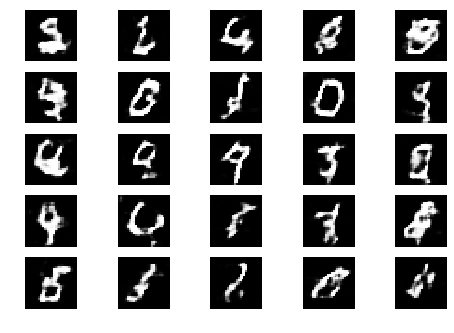

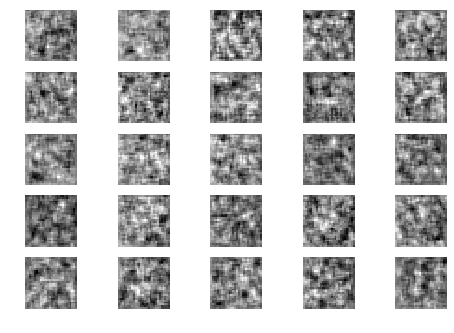

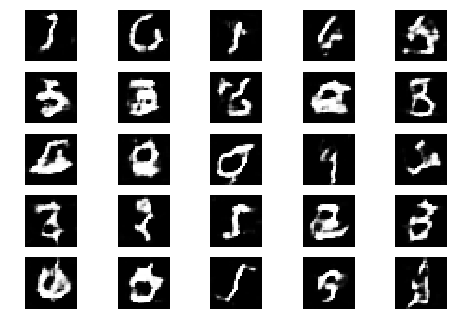

Epoch 1 Batch 1/375 [D loss: 0.654318, acc.: 59.38%] [G loss: 1.176535]
Epoch 1 Batch 2/375 [D loss: 0.645214, acc.: 78.12%] [G loss: 1.355252]
Epoch 1 Batch 3/375 [D loss: 0.691107, acc.: 50.00%] [G loss: 1.005584]
Epoch 1 Batch 4/375 [D loss: 0.671681, acc.: 65.62%] [G loss: 1.012417]
Epoch 1 Batch 5/375 [D loss: 0.473046, acc.: 81.25%] [G loss: 1.199322]
Epoch 1 Batch 6/375 [D loss: 0.735402, acc.: 59.38%] [G loss: 1.075955]
Epoch 1 Batch 7/375 [D loss: 0.631980, acc.: 68.75%] [G loss: 1.389521]
Epoch 1 Batch 8/375 [D loss: 0.749295, acc.: 46.88%] [G loss: 1.230123]
Epoch 1 Batch 9/375 [D loss: 0.696274, acc.: 62.50%] [G loss: 1.128997]
Epoch 1 Batch 10/375 [D loss: 0.749748, acc.: 50.00%] [G loss: 1.021827]
Epoch 1 Batch 11/375 [D loss: 0.847122, acc.: 50.00%] [G loss: 1.100558]
Epoch 1 Batch 12/375 [D loss: 0.597764, acc.: 65.62%] [G loss: 0.987838]
Epoch 1 Batch 13/375 [D loss: 0.581264, acc.: 75.00%] [G loss: 1.085399]
Epoch 1 Batch 14/375 [D loss: 0.536504, acc.: 75.00%] [G los

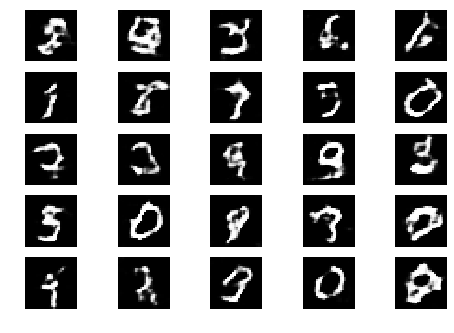

Epoch 1 Batch 101/375 [D loss: 0.572107, acc.: 78.12%] [G loss: 1.120288]


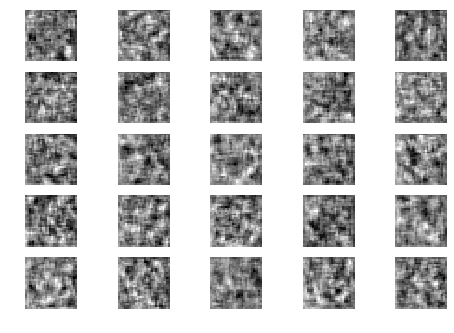

Epoch 1 Batch 102/375 [D loss: 0.576129, acc.: 71.88%] [G loss: 1.096378]


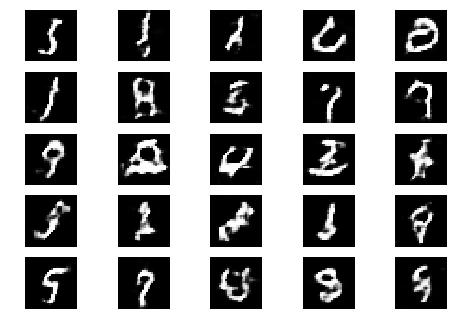

Epoch 1 Batch 103/375 [D loss: 0.820224, acc.: 40.62%] [G loss: 0.883310]
Epoch 1 Batch 104/375 [D loss: 0.615254, acc.: 62.50%] [G loss: 0.932660]
Epoch 1 Batch 105/375 [D loss: 0.780899, acc.: 46.88%] [G loss: 0.997342]
Epoch 1 Batch 106/375 [D loss: 0.564924, acc.: 65.62%] [G loss: 1.158143]
Epoch 1 Batch 107/375 [D loss: 0.734255, acc.: 56.25%] [G loss: 1.092649]
Epoch 1 Batch 108/375 [D loss: 0.790019, acc.: 59.38%] [G loss: 1.182063]
Epoch 1 Batch 109/375 [D loss: 0.589227, acc.: 84.38%] [G loss: 0.837870]
Epoch 1 Batch 110/375 [D loss: 0.758486, acc.: 50.00%] [G loss: 1.068111]
Epoch 1 Batch 111/375 [D loss: 0.882294, acc.: 50.00%] [G loss: 0.925027]
Epoch 1 Batch 112/375 [D loss: 0.600088, acc.: 71.88%] [G loss: 1.114304]
Epoch 1 Batch 113/375 [D loss: 0.647382, acc.: 68.75%] [G loss: 1.152495]
Epoch 1 Batch 114/375 [D loss: 0.640316, acc.: 62.50%] [G loss: 1.145448]
Epoch 1 Batch 115/375 [D loss: 0.678487, acc.: 56.25%] [G loss: 1.200572]
Epoch 1 Batch 116/375 [D loss: 0.69566

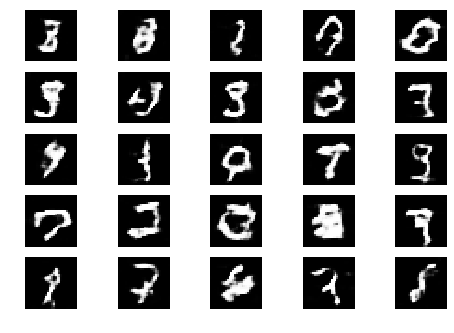

Epoch 1 Batch 201/375 [D loss: 0.734488, acc.: 50.00%] [G loss: 1.051780]
Epoch 1 Batch 202/375 [D loss: 0.790110, acc.: 50.00%] [G loss: 0.895398]


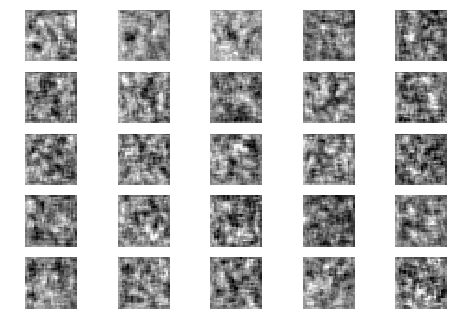

Epoch 1 Batch 203/375 [D loss: 0.781648, acc.: 46.88%] [G loss: 0.870930]
Epoch 1 Batch 204/375 [D loss: 0.605392, acc.: 65.62%] [G loss: 0.908605]


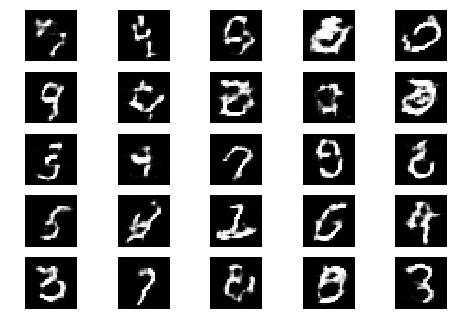

Epoch 1 Batch 205/375 [D loss: 0.629573, acc.: 71.88%] [G loss: 1.171873]
Epoch 1 Batch 206/375 [D loss: 0.753114, acc.: 53.12%] [G loss: 1.062890]
Epoch 1 Batch 207/375 [D loss: 0.677672, acc.: 50.00%] [G loss: 1.010604]
Epoch 1 Batch 208/375 [D loss: 0.778490, acc.: 56.25%] [G loss: 1.053245]
Epoch 1 Batch 209/375 [D loss: 0.799995, acc.: 43.75%] [G loss: 1.189373]
Epoch 1 Batch 210/375 [D loss: 0.830107, acc.: 46.88%] [G loss: 0.954812]
Epoch 1 Batch 211/375 [D loss: 0.777707, acc.: 50.00%] [G loss: 0.913510]
Epoch 1 Batch 212/375 [D loss: 0.771241, acc.: 43.75%] [G loss: 0.880126]
Epoch 1 Batch 213/375 [D loss: 0.653596, acc.: 53.12%] [G loss: 0.874444]
Epoch 1 Batch 214/375 [D loss: 0.636364, acc.: 71.88%] [G loss: 1.222818]
Epoch 1 Batch 215/375 [D loss: 0.637986, acc.: 71.88%] [G loss: 0.948249]
Epoch 1 Batch 216/375 [D loss: 0.561511, acc.: 78.12%] [G loss: 1.060938]
Epoch 1 Batch 217/375 [D loss: 0.590766, acc.: 68.75%] [G loss: 0.988031]
Epoch 1 Batch 218/375 [D loss: 0.80990

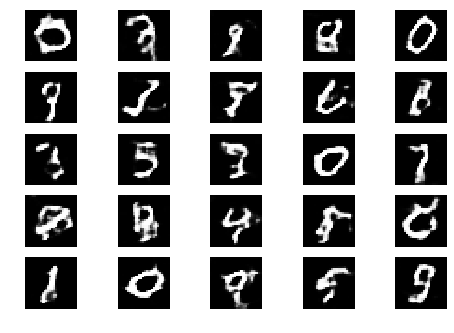

Epoch 1 Batch 301/375 [D loss: 0.734787, acc.: 56.25%] [G loss: 0.797273]
Epoch 1 Batch 302/375 [D loss: 0.642901, acc.: 56.25%] [G loss: 0.862885]
Epoch 1 Batch 303/375 [D loss: 0.656027, acc.: 71.88%] [G loss: 0.991939]


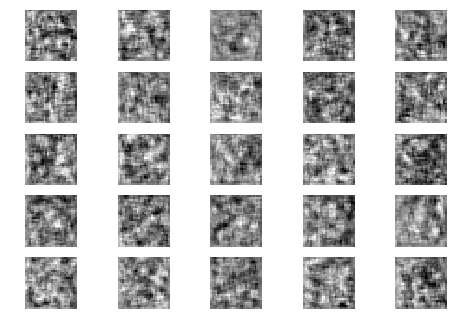

Epoch 1 Batch 304/375 [D loss: 0.472854, acc.: 81.25%] [G loss: 1.160529]
Epoch 1 Batch 305/375 [D loss: 0.691419, acc.: 56.25%] [G loss: 1.031842]
Epoch 1 Batch 306/375 [D loss: 0.690814, acc.: 53.12%] [G loss: 1.047683]


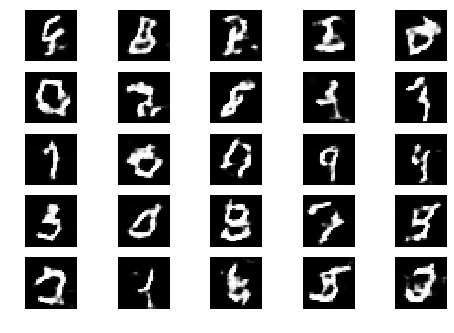

Epoch 1 Batch 307/375 [D loss: 0.620533, acc.: 68.75%] [G loss: 0.984770]
Epoch 1 Batch 308/375 [D loss: 0.616520, acc.: 68.75%] [G loss: 0.962138]
Epoch 1 Batch 309/375 [D loss: 0.674555, acc.: 59.38%] [G loss: 1.110569]
Epoch 1 Batch 310/375 [D loss: 0.585113, acc.: 75.00%] [G loss: 1.132934]
Epoch 1 Batch 311/375 [D loss: 0.679027, acc.: 46.88%] [G loss: 1.066676]
Epoch 1 Batch 312/375 [D loss: 0.692771, acc.: 59.38%] [G loss: 1.160597]
Epoch 1 Batch 313/375 [D loss: 0.691965, acc.: 71.88%] [G loss: 0.890398]
Epoch 1 Batch 314/375 [D loss: 0.589479, acc.: 71.88%] [G loss: 0.976494]
Epoch 1 Batch 315/375 [D loss: 0.550943, acc.: 71.88%] [G loss: 1.030636]
Epoch 1 Batch 316/375 [D loss: 0.582068, acc.: 62.50%] [G loss: 0.886580]
Epoch 1 Batch 317/375 [D loss: 0.783564, acc.: 50.00%] [G loss: 0.957649]
Epoch 1 Batch 318/375 [D loss: 0.710472, acc.: 50.00%] [G loss: 0.996797]
Epoch 1 Batch 319/375 [D loss: 0.607782, acc.: 65.62%] [G loss: 0.934324]
Epoch 1 Batch 320/375 [D loss: 0.58174

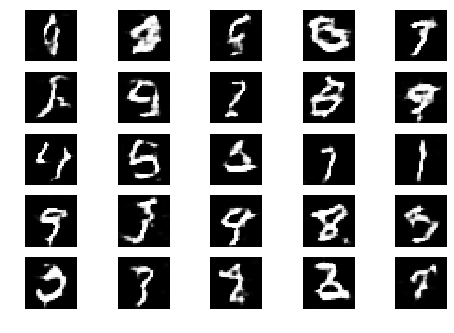

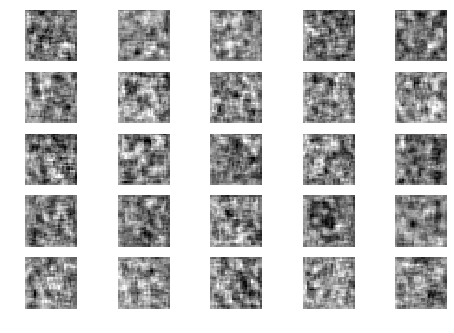

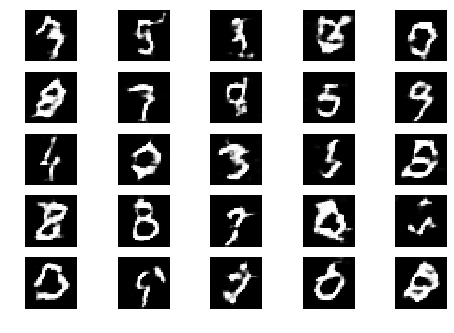

Epoch 2 Batch 1/375 [D loss: 0.731660, acc.: 62.50%] [G loss: 0.895653]
Epoch 2 Batch 2/375 [D loss: 0.678861, acc.: 56.25%] [G loss: 1.080855]
Epoch 2 Batch 3/375 [D loss: 0.646354, acc.: 65.62%] [G loss: 1.117909]
Epoch 2 Batch 4/375 [D loss: 0.790595, acc.: 46.88%] [G loss: 1.118381]
Epoch 2 Batch 5/375 [D loss: 0.625634, acc.: 62.50%] [G loss: 0.788129]
Epoch 2 Batch 6/375 [D loss: 0.579039, acc.: 71.88%] [G loss: 0.800961]
Epoch 2 Batch 7/375 [D loss: 0.601185, acc.: 65.62%] [G loss: 0.917053]
Epoch 2 Batch 8/375 [D loss: 0.648056, acc.: 62.50%] [G loss: 0.923262]
Epoch 2 Batch 9/375 [D loss: 0.672401, acc.: 62.50%] [G loss: 0.908213]
Epoch 2 Batch 10/375 [D loss: 0.877656, acc.: 37.50%] [G loss: 1.028880]
Epoch 2 Batch 11/375 [D loss: 0.685019, acc.: 53.12%] [G loss: 0.808792]
Epoch 2 Batch 12/375 [D loss: 0.626409, acc.: 71.88%] [G loss: 1.175084]
Epoch 2 Batch 13/375 [D loss: 0.752885, acc.: 53.12%] [G loss: 0.961541]
Epoch 2 Batch 14/375 [D loss: 0.699958, acc.: 59.38%] [G los

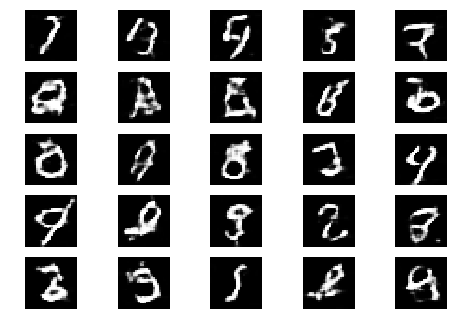

Epoch 2 Batch 101/375 [D loss: 0.663113, acc.: 53.12%] [G loss: 1.149245]


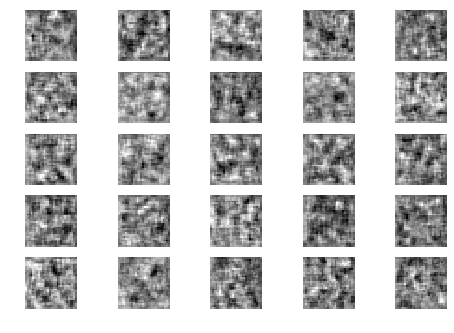

Epoch 2 Batch 102/375 [D loss: 0.558992, acc.: 68.75%] [G loss: 1.216980]


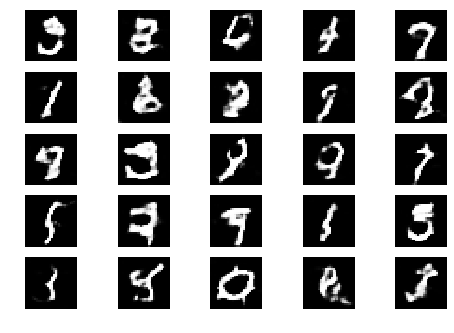

Epoch 2 Batch 103/375 [D loss: 0.696257, acc.: 62.50%] [G loss: 0.949580]
Epoch 2 Batch 104/375 [D loss: 0.735404, acc.: 37.50%] [G loss: 0.977529]
Epoch 2 Batch 105/375 [D loss: 0.709957, acc.: 53.12%] [G loss: 0.825685]
Epoch 2 Batch 106/375 [D loss: 0.680886, acc.: 59.38%] [G loss: 0.971676]
Epoch 2 Batch 107/375 [D loss: 0.663528, acc.: 46.88%] [G loss: 1.146742]
Epoch 2 Batch 108/375 [D loss: 0.634418, acc.: 65.62%] [G loss: 0.958524]
Epoch 2 Batch 109/375 [D loss: 0.775474, acc.: 53.12%] [G loss: 1.120968]
Epoch 2 Batch 110/375 [D loss: 0.724049, acc.: 62.50%] [G loss: 1.100480]
Epoch 2 Batch 111/375 [D loss: 0.772249, acc.: 40.62%] [G loss: 0.983396]
Epoch 2 Batch 112/375 [D loss: 0.794649, acc.: 40.62%] [G loss: 0.887953]
Epoch 2 Batch 113/375 [D loss: 0.571397, acc.: 65.62%] [G loss: 0.965823]
Epoch 2 Batch 114/375 [D loss: 0.504127, acc.: 78.12%] [G loss: 0.814403]
Epoch 2 Batch 115/375 [D loss: 0.653007, acc.: 62.50%] [G loss: 0.936719]
Epoch 2 Batch 116/375 [D loss: 0.80776

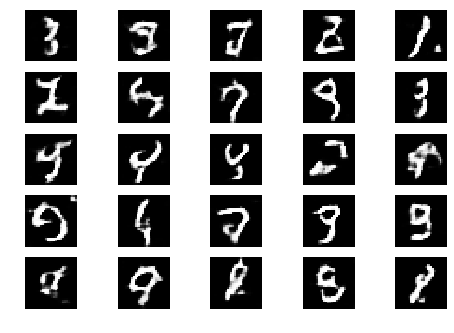

Epoch 2 Batch 201/375 [D loss: 0.706056, acc.: 62.50%] [G loss: 0.958934]
Epoch 2 Batch 202/375 [D loss: 0.726411, acc.: 62.50%] [G loss: 1.135733]


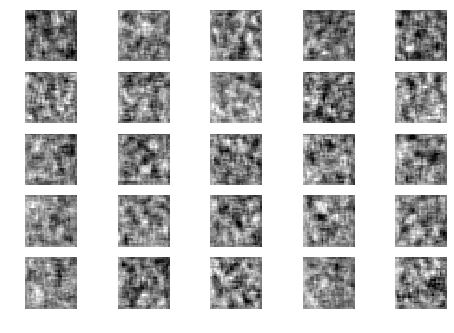

Epoch 2 Batch 203/375 [D loss: 0.642849, acc.: 62.50%] [G loss: 1.023520]
Epoch 2 Batch 204/375 [D loss: 0.754846, acc.: 53.12%] [G loss: 0.948388]


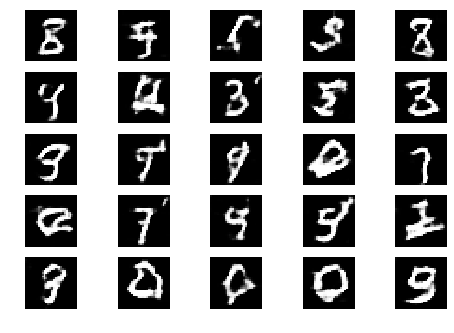

Epoch 2 Batch 205/375 [D loss: 0.857636, acc.: 34.38%] [G loss: 1.078838]
Epoch 2 Batch 206/375 [D loss: 0.820341, acc.: 43.75%] [G loss: 0.907284]
Epoch 2 Batch 207/375 [D loss: 0.683488, acc.: 56.25%] [G loss: 1.013575]
Epoch 2 Batch 208/375 [D loss: 0.667570, acc.: 65.62%] [G loss: 0.924224]
Epoch 2 Batch 209/375 [D loss: 0.720788, acc.: 40.62%] [G loss: 1.089085]
Epoch 2 Batch 210/375 [D loss: 0.673269, acc.: 59.38%] [G loss: 1.101606]
Epoch 2 Batch 211/375 [D loss: 0.698281, acc.: 50.00%] [G loss: 0.924156]
Epoch 2 Batch 212/375 [D loss: 0.658887, acc.: 59.38%] [G loss: 0.985089]
Epoch 2 Batch 213/375 [D loss: 0.667663, acc.: 53.12%] [G loss: 0.928354]
Epoch 2 Batch 214/375 [D loss: 0.726057, acc.: 59.38%] [G loss: 0.916068]
Epoch 2 Batch 215/375 [D loss: 0.851267, acc.: 37.50%] [G loss: 0.805730]
Epoch 2 Batch 216/375 [D loss: 0.527041, acc.: 84.38%] [G loss: 1.053097]
Epoch 2 Batch 217/375 [D loss: 0.808416, acc.: 40.62%] [G loss: 0.752210]
Epoch 2 Batch 218/375 [D loss: 0.65812

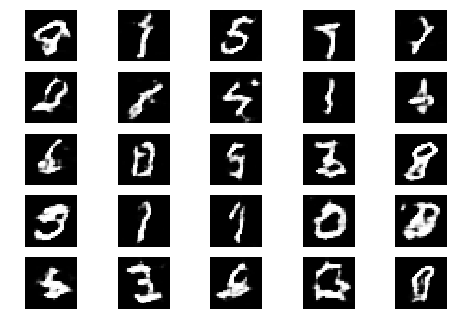

Epoch 2 Batch 301/375 [D loss: 0.780565, acc.: 50.00%] [G loss: 0.948528]
Epoch 2 Batch 302/375 [D loss: 0.716238, acc.: 59.38%] [G loss: 1.017872]
Epoch 2 Batch 303/375 [D loss: 0.583771, acc.: 71.88%] [G loss: 0.908840]


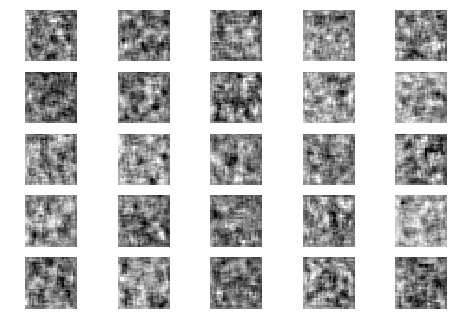

Epoch 2 Batch 304/375 [D loss: 0.713504, acc.: 62.50%] [G loss: 1.145979]
Epoch 2 Batch 305/375 [D loss: 0.733148, acc.: 56.25%] [G loss: 1.005343]
Epoch 2 Batch 306/375 [D loss: 0.765145, acc.: 50.00%] [G loss: 0.964215]


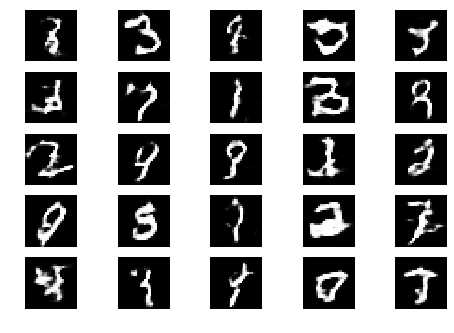

Epoch 2 Batch 307/375 [D loss: 0.639307, acc.: 59.38%] [G loss: 1.181594]
Epoch 2 Batch 308/375 [D loss: 0.648892, acc.: 62.50%] [G loss: 1.161709]
Epoch 2 Batch 309/375 [D loss: 0.895277, acc.: 34.38%] [G loss: 1.113919]
Epoch 2 Batch 310/375 [D loss: 0.680513, acc.: 56.25%] [G loss: 0.945962]
Epoch 2 Batch 311/375 [D loss: 0.606330, acc.: 68.75%] [G loss: 0.942674]
Epoch 2 Batch 312/375 [D loss: 0.760723, acc.: 53.12%] [G loss: 1.253086]
Epoch 2 Batch 313/375 [D loss: 0.842954, acc.: 46.88%] [G loss: 1.025151]
Epoch 2 Batch 314/375 [D loss: 0.792997, acc.: 46.88%] [G loss: 1.126330]
Epoch 2 Batch 315/375 [D loss: 0.654139, acc.: 62.50%] [G loss: 1.223389]
Epoch 2 Batch 316/375 [D loss: 0.674057, acc.: 56.25%] [G loss: 1.036436]
Epoch 2 Batch 317/375 [D loss: 0.799329, acc.: 34.38%] [G loss: 0.981721]
Epoch 2 Batch 318/375 [D loss: 0.717663, acc.: 56.25%] [G loss: 0.899766]
Epoch 2 Batch 319/375 [D loss: 0.712438, acc.: 46.88%] [G loss: 0.764994]
Epoch 2 Batch 320/375 [D loss: 0.63581

In [23]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
    generator1.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')

In [0]:
##files.download('generator1.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

